In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import tqdm as tqdm

# Special for plotting
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import sys
import os

# # Add the poligrain and mergeplg src directories to Python's path
sys.path.append(os.path.abspath("./poligrain/src"))
sys.path.append(os.path.abspath("./mergeplg/src"))


In [4]:
# Import submodules
import pycomlink as pycml
import poligrain as plg
import mergeplg as merge


In [5]:
# OpenMRG
ds_gauges = xr.open_dataset("data/andersson_2022_OpenMRG/gauges/openmrg_gauges_city.nc")
ds_gauges_smhi = xr.open_dataset("data/andersson_2022_OpenMRG/gauges/openmrg_gauges_smhi.nc")
ds_rad = xr.open_dataset("data/andersson_2022_OpenMRG/radar/openmrg_rad.nc")
ds_cmls = xr.open_dataset("data/processed_cml_OpenMRG.nc") 

In [6]:
# Slice in time 
start = '2015-08-01T00'
end = '2015-08-31T00'
ds_gauges = ds_gauges.sel(time = slice(start, end))
ds_gauges_smhi = ds_gauges_smhi.sel(time = slice(start, end))
ds_rad = ds_rad.sel(time = slice(start, end)) 
ds_cmls = ds_cmls.sel(time = slice(start, end)) 


In [7]:
ds_rad["rainfall_amount"] = ds_rad['R'] * (5 / 60)
# Resample to 15 min resolution
ds_rad = ds_rad.resample(time = '15min', label='right', closed='right').sum()

ds_cmls = ds_cmls.R_acc.resample(time = '15min', label='right', closed='right').sum()
ds_cmls = ds_cmls.reduce(np.nanmean, dim='sublink_id')


In [8]:
# Threshold lower values
radar_zero = 0.01  # here in sum mm over 15 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

# Project data

In [9]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [10]:
# Project OpenMRG data
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.longitude, ds_gauges.latitude, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.longitude, ds_gauges_smhi.latitude, ref_str
    )
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates( 
    ds_rad.lon, ds_rad.lat, ref_str
)

# Closest municip to SMHI

In [11]:
n_closest = 3

# Get the n closest netatmo to SMHI
closest = plg.spatial.get_closest_points_to_point(
    ds_gauges_smhi,
    ds_gauges,
    max_distance=10000,
    n_closest = n_closest
).isel(id = 0).neighbor_id.data

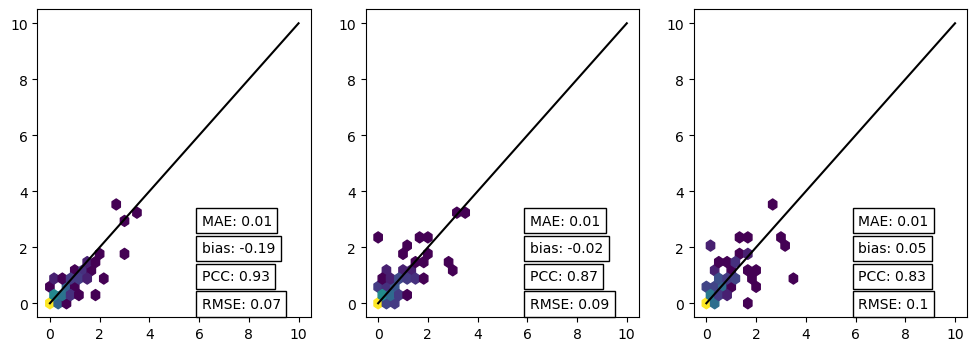

In [12]:
fig, ax = plt.subplots(1, n_closest, figsize=(n_closest*4,4))
for i, id in enumerate(closest):
    ground = ds_gauges_smhi.rainfall_amount.isel(id = 0).data
    tar = ds_gauges.rainfall_amount.sel(id = id).data
    keep = np.ones(tar.size).astype(bool)
    ax[i].hexbin(
        ground,
        tar,
        gridsize=30,
        extent=[0, 10, 0, 10],
        mincnt=1,
        bins = 'log'
    )
    ax[i].plot([0, 10], [0, 10], 'k')

    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )


# Closest CMLs to SMHI

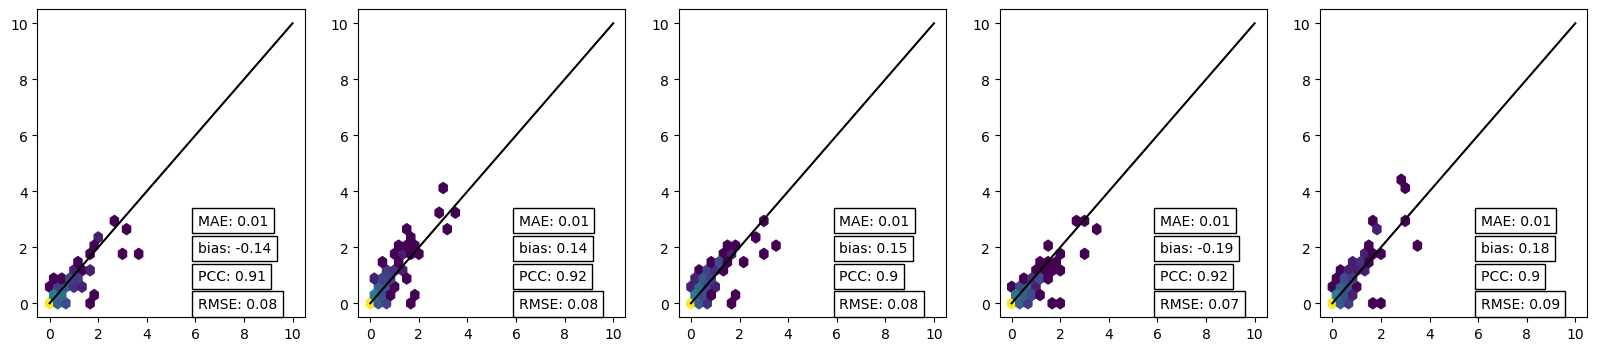

In [13]:
n_closest = 5
cml_rain = ds_cmls.sel(time=ds_gauges_smhi.time)


# Get the n closest netatmo to SMHI
closest = plg.spatial.get_closest_points_to_point(
    ds_gauges_smhi,
    ds_cmls.rename({'cml_id':'id'}),
    max_distance=10000,
    n_closest = n_closest
).isel(id = 0).neighbor_id.data

fig, ax = plt.subplots(1, n_closest, figsize=(n_closest*4,4))
for i, id in enumerate(closest):
    ground = ds_gauges_smhi.rainfall_amount.isel(id = 0).data
    tar = cml_rain.sel(cml_id = id).data
    keep = np.ones(tar.size).astype(bool)
    ax[i].hexbin(
        ground,
        tar,
        gridsize=30,
        extent=[0, 10, 0, 10],
        mincnt=1,
        bins = 'log'
    )
    ax[i].plot([0, 10], [0, 10], 'k')

    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )


# Adjust rainfall fields

In [14]:
time = ds_cmls.time.data[0]
print(ds_rad.sel(time=[time]).rainfall_amount.shape)
print(ds_cmls.sel(time=[time]).shape)

(1, 48, 37)
(359, 1)


In [15]:
# Additive IDW
merger = merge.merge.MergeAdditiveIDW()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_idw"] = xr.concat(adjusted_rainfall, dim="time")

100%|█| 2885/2885 [00:17<00:00,


In [16]:
# Additive Block Kriging
merger = merge.merge.MergeAdditiveBlockKriging()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_bk"] = xr.concat(adjusted_rainfall, dim="time")

100%|█| 2885/2885 [04:31<00:00,


In [17]:
# Block Kriging With External Drift
merger = merge.merge.MergeBlockKrigingExternalDrift()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.sel(time=[time]),
        )
    )
ds_rad["adjust_ked"] = xr.concat(adjusted_rainfall, dim="time")

100%|█| 2885/2885 [03:39<00:00,


In [18]:
# saving adjusted fields
ds_rad.to_netcdf('data/adjusted_radar_OpenMRG.nc')

# Plot adjusted fields

In [19]:
cmap_colors = [
    (0, "white"),
    (radar_zero, "white"),
    (radar_zero, (0.5, 0.75, 0.25, 1.0)),
    (1, "blue"),
]  # white -> green-yellow mix -> dark blue
cmap_rain = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

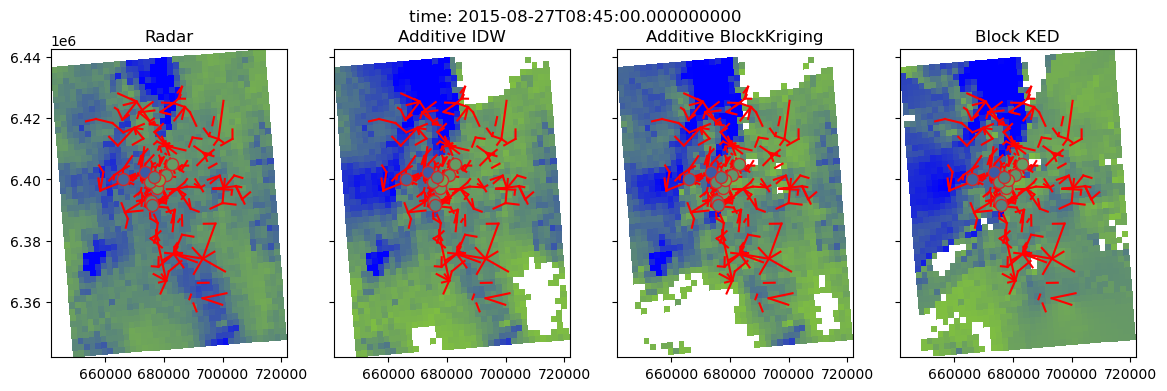

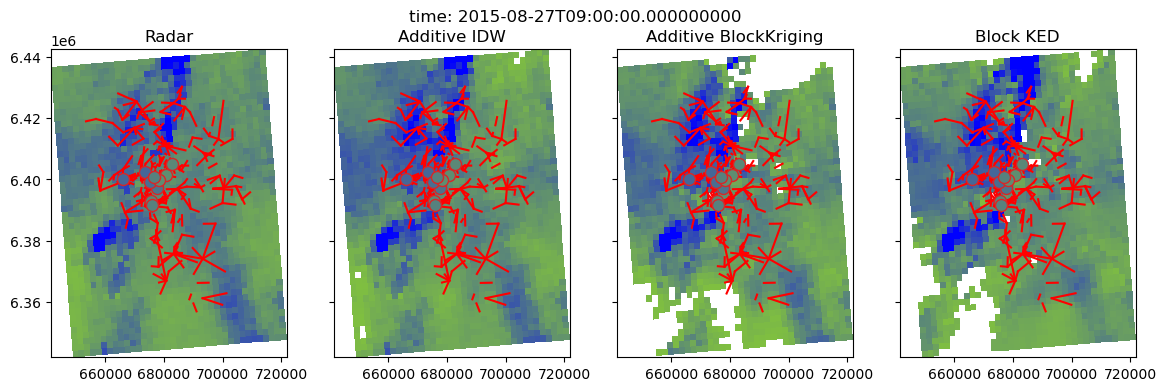

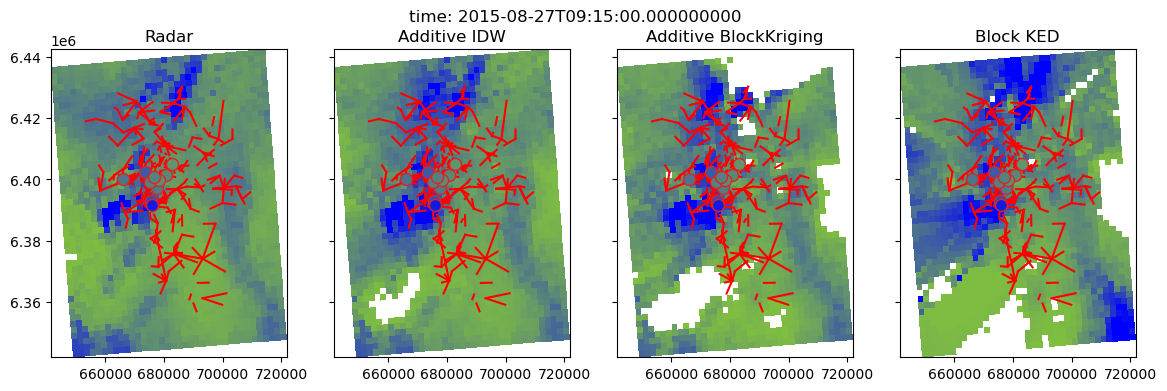

In [20]:
vmax = 3  # max color

# Time interval to plot
time_start = "2015-08-27T08:45"
time_end = "2015-08-27T09:15"
for time in ds_cmls.sel(time=slice(time_start, time_end)).time:
    fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
    ax[0].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_amount.data,
        vmin=0,
        vmax=vmax,
        cmap=cmap_rain,
    )

    ax[1].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).adjust_idw.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[2].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).adjust_bk.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[3].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).adjust_ked.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )

    ax[0].set_title("Radar")
    ax[1].set_title("Additive IDW")
    ax[2].set_title("Additive BlockKriging")
    ax[3].set_title("Block KED")
    plt.suptitle('time: '+str(time.values))

    for ax_i in range(len(ax)):
        for cml_id in ds_cmls.cml_id:
            ax[ax_i].plot(
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_x,
                    ds_cmls.sel(cml_id=cml_id).site_1_x,
                ],
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_y,
                    ds_cmls.sel(cml_id=cml_id).site_1_y,
                ],
                "red",
                zorder=1,
            )

    for ax_i in range(len(ax)):
        for station_id in ds_gauges.id:
            ax[ax_i].scatter(
                station_id.x,
                station_id.y,
                c=ds_gauges.sel(id=station_id, time=time).rainfall_amount,
                cmap=cmap_rain,
                edgecolors="C3",
                vmin=0,
                vmax=vmax,
                s=75,
                zorder=2,
            )
    plt.show()

# Compare adjusted fields to CML observations

In [21]:
intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.data,
    y1_line=ds_cmls.site_0_lat.data,
    x2_line=ds_cmls.site_1_lon.data,
    y2_line=ds_cmls.site_1_lat.data,
    cml_id=ds_cmls.cml_id.data,
    x_grid=ds_rad.lon.data,
    y_grid=ds_rad.lat.data,
    grid_point_location="center",
)

ds_cmls["rainfall_radar"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.rainfall_amount,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_idw"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_idw,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_bk"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_bk,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_ked"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_ked,
    intersect_weights=intersect_weights,
)

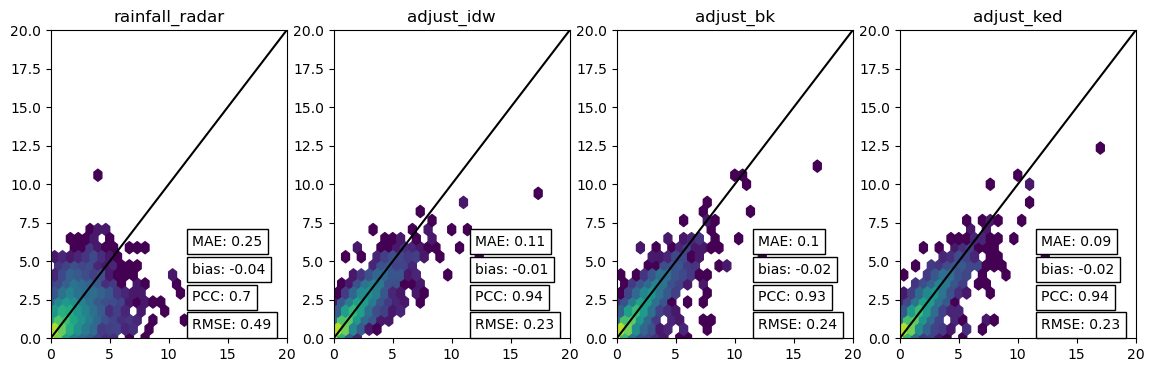

In [22]:
max_ext = 20
extent = [0, max_ext, 0, max_ext]
gridsize = 30

pred_models = [
    ds_cmls.rainfall_radar,
    ds_cmls.adjust_idw,
    ds_cmls.adjust_bk,
    ds_cmls.adjust_ked,
]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_cmls.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.T.ravel()

    keep = (ground > 0) & (tar > 0)

    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(pred_models[i].name)
    ax[i].set_xlim(0, extent[1])
    ax[i].set_ylim(0, extent[1])

# Compare to city rain gauges

In [23]:
ds_gauges = ds_gauges.rename({'longitude':'lon', 'latitude':'lat'})
ds_rad = ds_rad.sel(time=ds_gauges.time)

In [24]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), # had to set time equal to zero.. !
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best",
)

In [25]:
ds_gauges['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_idw'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_idw,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_bk'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_bk,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_ked'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_ked,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

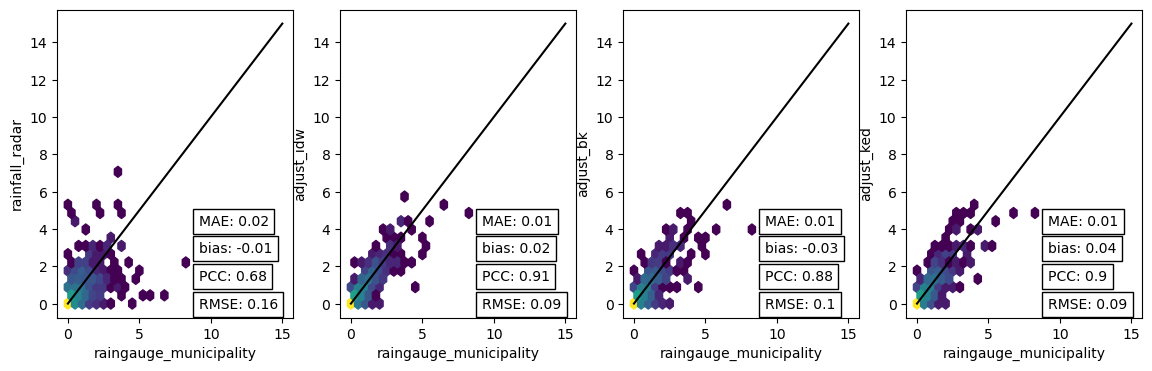

In [26]:
max_ = 15
extent = [0, max_, 0, max_]
gridsize = 30

pred_models = [ds_gauges.rainfall_radar, ds_gauges.adjust_idw, ds_gauges.adjust_bk, ds_gauges.adjust_ked]

fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharex = True)
ground = ds_gauges.rainfall_amount.data.ravel()
radar_rainfall = ds_gauges.rainfall_radar.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = np.ones(ground.shape).astype(bool)
    
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")
    ax[i].set_ylabel(pred_models[i].name)
    ax[i].set_xlabel('raingauge_municipality')

plt.show()

# Compare to SMHI rain gauge

In [27]:
ds_gauges_smhi = ds_gauges_smhi.rename({'longitude':'lon', 'latitude':'lat'})
ds_rad = ds_rad.sel(time=ds_gauges_smhi.time)

In [28]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), # had to set time equal to zero.. !
    da_point_data=ds_gauges_smhi.isel(time = 0),
    nnear=1,
    stat="best",
)

In [29]:
ds_gauges_smhi['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges_smhi['adjust_idw'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_idw,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges_smhi['adjust_bk'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_bk,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges_smhi['adjust_ked'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_ked,
    da_point_data=ds_gauges_smhi.rainfall_amount,  # Why do we require rainfal amount?
)

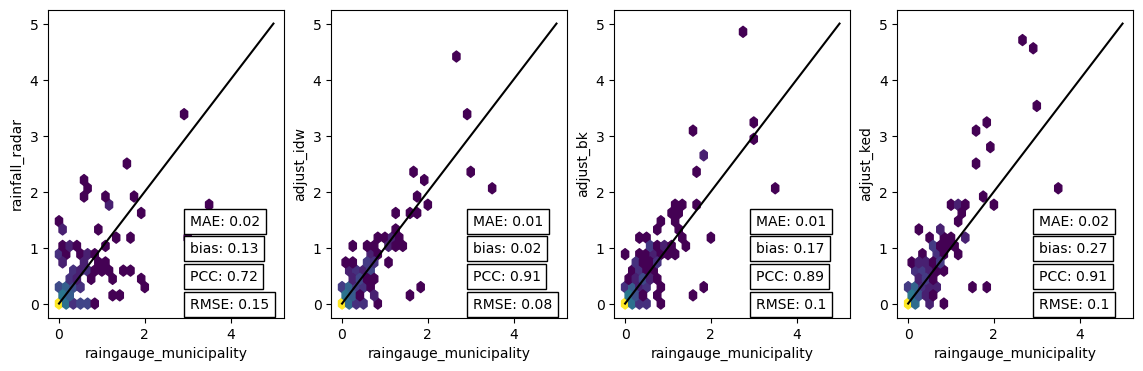

In [30]:
max_ = 5
extent = [0, max_, 0, max_]
gridsize = 30

pred_models = [ds_gauges_smhi.rainfall_radar, ds_gauges_smhi.adjust_idw, ds_gauges_smhi.adjust_bk, ds_gauges_smhi.adjust_ked]

fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharex = True)
ground = ds_gauges_smhi.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()
    keep = np.ones(ground.shape).astype(bool)
    
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")
    ax[i].set_ylabel(pred_models[i].name)
    ax[i].set_xlabel('raingauge_municipality')

plt.show()

# OpenRainER

In [1]:
%load_ext autoreload
%autoreload 2
    
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import tqdm as tqdm

# Special for plotting
from matplotlib.colors import LinearSegmentedColormap

import sys
import os

# # Add the poligrain and mergeplg src directories to Python's path
sys.path.append(os.path.abspath("./poligrain/src"))
sys.path.append(os.path.abspath("./mergeplg/src"))

# Import submodules
import pycomlink as pycml
import poligrain as plg
import mergeplg as merge


In [2]:
# OpenRainER
ds_gauges = xr.open_dataset("data/covi_2024_OpenRainER/AWS_rainfall.nc")
ds_rad = xr.open_dataset("data/covi_2024_OpenRainER/openrainer_radar.nc")
ds_cmls = xr.open_dataset("data/processed_cml_OpenRainER.nc") 


In [3]:
#ds_cmls = ds_cmls.sel(time=ds_rad.time)
ds_rad = ds_rad.rename({'lon':'x', 'lat':'y'}) # store old lon/lat coordinates
ds_rad = ds_rad.rename({'lon_grid':'lon', 'lat_grid':'lat'}) # rename the grid
ds_gauges = ds_gauges.rename({'longitude':'lon', 'latitude':'lat'}) # rename gauge coord to standard 


In [4]:
# Slice in time 
start = '2022-08-18T13:00'
end = '2022-08-19T00:00'
ds_gauges = ds_gauges.sel(time = slice(start, end))
ds_rad = ds_rad.sel(time = slice(start, end)) 
ds_cmls = ds_cmls.sel(time = slice(start, end)) 

In [5]:
# Resample to 15 min resolution
ds_cmls = ds_cmls[['R', 'rainfall_radar']].resample(time = '15min', label='right', closed='right').sum()
#ds_cmls = ds_cmls.reduce(np.nanmean, dim='sublink_id')

# Threshold lower values
radar_zero = 0.2  # here in sum mm over 15 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

ds_cmls['rainfall_radar'] = xr.where(
    ds_cmls.rainfall_radar > radar_zero, ds_cmls.rainfall_radar, 0
)

ds_cmls['R'] = xr.where(
    ds_cmls.R > radar_zero, ds_cmls.R, 0
)

In [6]:
ds_cmls = ds_cmls.sel(time = ds_rad.time)

In [7]:
ref_str = "EPSG:32632"

# Project OpenRainER data
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates( 
    ds_rad.lon, ds_rad.lat, ref_str
)

### Remove duplicate CMLs, keeping those that agree best with radar

In [8]:
# Find duplicate CMLs, this cell is intended for poligrain
def find_duplicates(ds_cmls, separation_distance):
    # Dictionary for storing CML and its neighbors
    groups = {}
    
    # np arrays for faster lookup
    cml_ids = ds_cmls.cml_id.data
    site_0_x = ds_cmls.site_0_x.data
    site_1_x = ds_cmls.site_1_x.data
    site_0_y = ds_cmls.site_0_y.data
    site_1_y = ds_cmls.site_1_y.data
    
    # Identify lines that are close
    for cml_i in range(cml_ids.size):
        x_0 = site_0_x[cml_i]
        x_1 = site_1_x[cml_i] 
        y_0 = site_0_y[cml_i] 
        y_1 = site_1_y[cml_i] 
        
        cml_add = []
        for cml_i_check in range(cml_ids.size):
            x_0_check = site_0_x[cml_i_check]
            x_1_check = site_1_x[cml_i_check]
            y_0_check = site_0_y[cml_i_check] 
            y_1_check = site_1_y[cml_i_check] 
    
            # Check distance between endpoints
            distance_0_0 = np.sqrt((x_0 - x_0_check)**2 + (y_0 - y_0_check)**2) < separation_distance
            distance_1_1 = np.sqrt((x_1 - x_1_check)**2 + (y_1 - y_1_check)**2) < separation_distance
            
            # Check distance between endpoints, opposite way
            distance_0_1 = np.sqrt((x_0 - x_1_check)**2 + (y_0 - y_1_check)**2) < separation_distance
            distance_1_0 = np.sqrt((x_1 - x_0_check)**2 + (y_1 - y_0_check)**2) < separation_distance
    
            # Check if enpoints are close, both ways
            if (distance_0_0 & distance_1_1) | (distance_0_1 & distance_1_0):
                cml_add.append(str(cml_ids[cml_i_check]))
                
        groups[str(cml_ids[cml_i])] = cml_add
    return groups

In [9]:
# Sometimes one CML is close to several groups, iteration is needed
# Keep CMLs where the radar has some observations:
iterate = True
while iterate:
    best_cml_id = []
    groups = find_duplicates(ds_cmls, separation_distance=2000)
    n_elements = np.array([len(groups[cml_id]) for cml_id in groups.keys()])

    # Break while loop when all CMLs have only itself as closest
    if (n_elements == 1).all():
        iterate = False
        
    for cml_id in groups.keys():
        nearby_cmls = groups[cml_id].copy()
        if len(nearby_cmls) > 1: # more than self
            rmse = []
            for cml_id_check in nearby_cmls:
                rad = ds_cmls.sel(cml_id = cml_id_check).rainfall_radar.data
                cml = ds_cmls.sel(cml_id = cml_id_check).R.data
                keep = rad > 0
                if rad[keep].size >= 1: # need at least one positive radar observation
                    rmse.append(np.mean(np.abs(rad[keep] - cml[keep])))
                else:
                    rmse.append(np.nan)

            # Turn to numpy array
            rmse = np.array(rmse)

            # If all values are nan
            if not np.isnan(rmse).all():
                # Replace possible nan by max value
                rmse[np.isnan(rmse)] = np.nanmax(rmse)

                # Use CML-radar with best match
                best_cml_id.append(nearby_cmls[np.argmin(rmse)])
        else:
            best_cml_id.append(cml_id)
    # then remove duplicates
    ds_cmls = ds_cmls.sel(cml_id = np.unique(best_cml_id))


### Remove cml observations that is too different from the radar, or other CMLs if available

In [10]:
# # CML observations less or larger than radar times these factors will be ignored
# radar_factors = [0.2, 20]

# # CML observations outside this variance will be removed
# std_bound = 1

# # Number of CMLs needed for using nearby CMLs in filter
# n_min = 3

# # Neighbourhood distance and size
# max_distance = 10000
# n_closest = 20

# # List for storing qc cml timeseries
# cmls_qc = []

# # Get CML neighbourhood
# closest_cmls = plg.spatial.get_closest_points_to_point(
#     ds_cmls.rename({'cml_id':'id'}), 
#     ds_cmls.rename({'cml_id':'id'}), 
#     max_distance=max_distance, 
#     n_closest=n_closest
# )

# # Array for storing qc cml data
# cml_qc = np.zeros([ds_cmls.time.size, ds_cmls.cml_id.size])
# for cml_id in ds_cmls.cml_id.data:
#     # Get id of closest neighbors
#     neighbours = closest_cmls.sel(id = cml_id).neighbor_id.dropna(dim = 'n_closest').data

#     # Get the time series
#     ds_cml_check = ds_cmls.R.sel(cml_id = [cml_id])
#     ds_radar_check = ds_cmls.rainfall_radar.sel(cml_id = [cml_id])
    
#     # If few neighbours, use radar only
#     if neighbours.size < n_min:
#         # Set flagged observations to nan
#         cmls_qc.append(xr.where(
#             (ds_cml_check < ds_radar_check*radar_factors[0]) | 
#             (ds_cml_check > ds_radar_check*radar_factors[1]), 
#             np.nan, 
#             ds_cml_check
#         ))
        
#     # If more CMLs, also use nearby CMLs to filter good or bad CMLs
#     else:
#         # Get CML observations from neighborhood
#         cml_neighbours = ds_cmls.R.sel(cml_id = neighbours)
        
#         # Get radar observations from neighbourhood and set zeros to nan (these are ignored)
#         radar_neighbours = xr.where(ds_cmls.rainfall_radar == 0, np.nan, ds_cmls.rainfall_radar).sel(cml_id = neighbours)
        
#         # Get difference between radar and CML
#         diff_neighbours = cml_neighbours - radar_neighbours
        
#         lower_bound = (diff_neighbours.median() - diff_neighbours.std()*std_bound)
#         upper_bound = (diff_neighbours.median() + diff_neighbours.std()*std_bound)
        
#         # Remove flagged timesteps
#         cmls_qc.append(xr.where(
#             (ds_cml_check < ds_radar_check*radar_factors[0]) | 
#             (ds_cml_check > ds_radar_check*radar_factors[1]) | 
#             (ds_cml_check > upper_bound) | 
#             (ds_cml_check < lower_bound),
#             np.nan, 
#             ds_cml_check
#         ))


# ds_cmls['R'] = xr.concat(cmls_qc, dim = 'cml_id')

### Remove cmls that generate large variance according to the variogram (estimated from cml midpoints..)

In [11]:
# import pykrige

In [12]:
# #Keep observation with variance less than this factor
# variance_factor = 2 # This is a tuning parameter
# cmls_qc = []
# for time in ds_cmls.time.data:
#    cml = ds_cmls.sel(time = time).R.data.ravel()
#    radar = ds_cmls.rainfall_radar.sel(time = time).data.ravel()
#    x0 = np.hstack([ds_cmls.y.data.reshape(-1, 1), ds_cmls.x.data.reshape(-1, 1)])
   
#    # Use only observations where the radar observed rainfall
#    skip = (~(radar > 0)) | np.isnan(cml)
#    ind_nonzero = np.where(~skip)[0]
#    ind_zero = np.where(skip)[0]
   
#    # Set cml obs where radar is zero to nan
#    cml[ind_zero] = np.nan
   
#    # Estimate difference between cml and radar
#    diff = cml - radar

#    if x0[ind_nonzero, 1].size > 5: # using same min-bs as in mergeplg
   
#        # Set CML with no radar to nan
#        ok = pykrige.OrdinaryKriging(x0[ind_nonzero, 1], x0[ind_nonzero, 0], diff[ind_nonzero], variogram_model='exponential')
#        def variogram(h):
#            return ok.variogram_function(ok.variogram_model_parameters, h)
       
#        diff_mat = 0.5*(diff - diff.reshape(-1, 1))**2
#        dist_mat = np.sqrt((x0[:, 0] - x0[:, 0].reshape(-1, 1))**2 + (x0[:, 1] - x0[:, 1].reshape(-1, 1))**2)
       
#        # keep observations that generates a variance smaller than the the variogram + x*sill
#        max_keep = variogram(dist_mat) + variance_factor*ok.variogram_model_parameters[0]
       
#        # Identify CMLs to remove
#        ind_mask = np.where(((diff_mat  > max_keep).sum(axis = 0) > 1))[0]
#        cml[ind_mask] = np.nan
#    else:
#        cml[:] = np.nan

#    ds = ds_cmls.sel(time = [time]).copy()
#    ds['R_qc'] = ('cml_id', cml)
#    cmls_qc.append(ds)
   
# ds_cmls['R'] = xr.concat(cmls_qc, dim = 'time').R_qc

In [13]:
ds_cmls = ds_cmls.transpose('time', 'cml_id')
ds_rad = ds_rad.transpose('time', 'y', 'x')

Text(0.5, 0, 'raingauges')

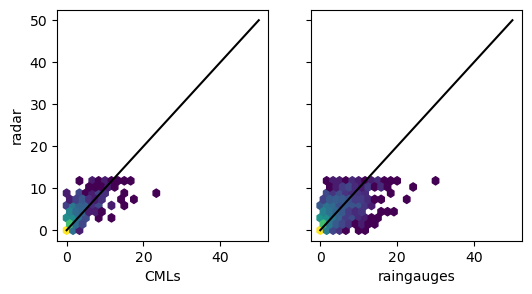

In [14]:
ds_rad = ds_rad.sel(time=ds_gauges.time)
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), # had to set time equal to zero.. !
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best",
)

ds_gauges['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)
ds_cml_h = ds_cmls#.resample(time = '60min').sum()
ds_gauges_h = ds_gauges#.resample(time = '60min').sum()

max_x = 50
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
ax[0].hexbin(
    ds_cml_h.R.data.ravel(),
    ds_cml_h.rainfall_radar.data.ravel(),
    mincnt=1,
    extent=[0, max_x, 0, max_x],
    bins = 'log',
    gridsize=30,

)
ax[0].plot([0, max_x], [0, max_x], 'k') 

ax[1].hexbin(
    ds_gauges_h.rainfall_amount.data.ravel(),
    ds_gauges_h.rainfall_radar.data.ravel(),
    mincnt=1,
    extent=[0, max_x, 0, max_x],
    bins = 'log',
    gridsize=30,
)
ax[1].plot([0, max_x], [0, max_x], 'k') 
ax[0].set_ylabel('radar')
ax[0].set_xlabel('CMLs')
ax[1].set_xlabel('raingauges')

In [17]:
# Additive IDW
merger = merge.merge.MergeAdditiveIDW()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.R.sel(time=[time]),
        )
    )
ds_rad["adjust_idw"] = xr.concat(adjusted_rainfall, dim="time")

100%|█████████████████████████████████████| 45/45 [00:05<00:00,  7.98it/s]


In [18]:
# Additive Block Kriging
merger = merge.merge.MergeAdditiveBlockKriging()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data):
    # Perform adjustment for one timestep
    adjusted_rainfall.append(
        merger.adjust(
            ds_rad.sel(time=[time]).rainfall_amount,
            da_cml=ds_cmls.R.sel(time=[time]),
        )
    )
ds_rad["adjust_bk"] = xr.concat(adjusted_rainfall, dim="time")

100%|█████████████████████████████████████| 45/45 [02:10<00:00,  2.91s/it]


In [19]:
# Block Kriging With External Drift
merger = merge.merge.MergeBlockKrigingExternalDrift()

adjusted_rainfall = []
for time in tqdm.tqdm(ds_cmls.time.data[11:]):
    rad = ds_rad.sel(time=[time]).rainfall_amount.copy()
    cml = ds_cmls.sel(time=[time]).copy()

    # Try to adjust radar field
    adjusted_field = merger.adjust(rad, cml.R)

    # If KED fails, use MergeAdditiveIDW
    if (adjusted_field < 0).any():
        merger2 = merge.merge.MergeAdditiveIDW()
        adjusted_field = merger2.adjust(rad, cml.R)

        # Fix any remaining zero-values 
        adjusted_field = xr.where(adjusted_field > 0, adjusted_field, rad)
    
    adjusted_rainfall.append(adjusted_field)
    
ds_rad["adjust_ked"] = xr.concat(adjusted_rainfall, dim="time")

100%|█████████████████████████████████████| 34/34 [02:53<00:00,  5.10s/it]


In [20]:
# # CML nearest neightbour interpolation
# adjusted_rainfall = np.zeros([ds_rad.time.size, ds_rad.y.size, ds_rad.x.size])
# cml_x = ds_cmls.x.data.ravel()
# cml_y = ds_cmls.y.data.ravel()
# rad_xs = ds_rad.xs.data
# rad_ys = ds_rad.ys.data

# for xi in tqdm.tqdm(range(ds_rad.x.size)):
#     for yi in range(ds_rad.y.size):
#         # get closest CML number (a bit brute force)
#         closest_cml_i = np.argmin((cml_x - rad_xs[yi, xi])**2 + (cml_y - rad_ys[yi, xi])**2)
#         cml_val = ds_cmls.R.isel(cml_id = closest_cml_i).data
        
#         adjusted_rainfall[:, yi, xi] = cml_val
            
# ds_rad["cml_closest"] = (("time", "y", "x"), adjusted_rainfall)

In [21]:
# # CML nearest neightbour interpolation
# adjusted_rainfall = np.zeros([ds_rad.time.size, ds_rad.y.size, ds_rad.x.size])
# cml_x = ds_cmls.x.data.ravel()
# cml_y = ds_cmls.y.data.ravel()
# rad_xs = ds_rad.xs.data
# rad_ys = ds_rad.ys.data

# for xi in tqdm.tqdm(range(ds_rad.x.size)):
#     for yi in range(ds_rad.y.size):
#         # get closest CML number (a bit brute force)
#         closest_cml_i = np.argmin((cml_x - rad_xs[yi, xi])**2 + (cml_y - rad_ys[yi, xi])**2)
#         cml_val = ds_cmls.R_qc.isel(cml_id = closest_cml_i).data
#         rad_val = ds_cmls.rainfall_radar.isel(cml_id = closest_cml_i).data
#         adjusted_rainfall[:, yi, xi] = cml_val - rad_val
            
# ds_rad["diff_closest"] = (("time", "y", "x"), adjusted_rainfall)

In [22]:
# # gauges nearest neightbour interpolation
# adjusted_rainfall = np.zeros([ds_rad.time.size, ds_rad.y.size, ds_rad.x.size])
# cml_x = ds_gauges.x.data.ravel()
# cml_y = ds_gauges.y.data.ravel()
# rad_xs = ds_rad.xs.data
# rad_ys = ds_rad.ys.data

# for xi in tqdm.tqdm(range(ds_rad.x.size)):
#     for yi in range(ds_rad.y.size):
#         # get closest CML number (a bit brute force)
#         closest_cml_i = np.argmin((cml_x - rad_xs[yi, xi])**2 + (cml_y - rad_ys[yi, xi])**2)
#         cml_val = ds_gauges.isel(id = closest_cml_i).rainfall_amount.data
        
#         adjusted_rainfall[:, yi, xi] = cml_val
            
# ds_rad["gauge_closest"] = (("time", "y", "x"), adjusted_rainfall)

In [23]:
# saving adjusted fields
ds_rad.to_netcdf('data/adjusted_radar_OpenRainER.nc')

# Compare adjusted fields to CML observations

In [24]:
intersect_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_lon.data,
    y1_line=ds_cmls.site_0_lat.data,
    x2_line=ds_cmls.site_1_lon.data,
    y2_line=ds_cmls.site_1_lat.data,
    cml_id=ds_cmls.cml_id.data,
    x_grid=ds_rad.lon.data,
    y_grid=ds_rad.lat.data,
    grid_point_location="center",
)

# ds_cmls["rainfall_radar2"] = plg.spatial.get_grid_time_series_at_intersections(
#     grid_data=ds_rad.rainfall_amount,
#     intersect_weights=intersect_weights,
# )

ds_cmls["adjust_idw"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_idw,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_bk"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_bk,
    intersect_weights=intersect_weights,
)

ds_cmls["adjust_ked"] = plg.spatial.get_grid_time_series_at_intersections(
    grid_data=ds_rad.adjust_ked,
    intersect_weights=intersect_weights,
)

# ds_cmls["cml_closest"] = plg.spatial.get_grid_time_series_at_intersections(
#     grid_data=ds_rad.cml_closest,
#     intersect_weights=intersect_weights,
# )

In [25]:
#for cml_id in ds_cmls.cml_id:
#    ds_cmls.R.sel(cml_id = cml_id).plot(label='cml')
#3    ds_cmls.rainfall_radar.sel(cml_id = cml_id).plot(label='radar')
#    ds_cmls.adjust_bk.sel(cml_id = cml_id).plot(label='adjusted')
#    plt.legend()
#    plt.show()

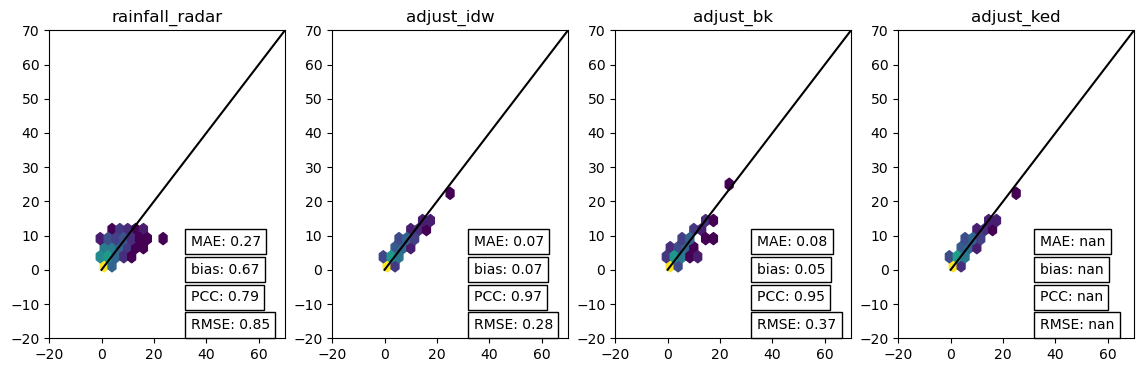

In [26]:
max_ext = 70
extent = [-20, max_ext, -20, max_ext]
gridsize = 30

pred_models = [
    ds_cmls.rainfall_radar,
    ds_cmls.adjust_idw,
    ds_cmls.adjust_bk,
    ds_cmls.adjust_ked,
    # ds_cmls.cml_closest,

]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_cmls.R.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = np.ones(ground.size).astype(bool) #(ground > 0) & (tar > 0)

    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")

    ax[i].set_title(pred_models[i].name)
    ax[i].set_xlim(extent[0], extent[1])
    ax[i].set_ylim(extent[0], extent[1])

# Compare to rain gauge

In [27]:
ds_gauges = ds_gauges.rename({'longitude':'lon', 'latitude':'lat'})
ds_rad = ds_rad.sel(time=ds_gauges.time)

ValueError: cannot rename 'longitude' because it is not a variable or dimension in this dataset

In [28]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), # had to set time equal to zero.. !
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best",
)

In [29]:
ds_gauges['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_idw'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_idw,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_bk'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_bk,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

ds_gauges['adjust_ked'] = get_grid_at_points(
    da_gridded_data=ds_rad.adjust_ked,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

# ds_gauges['gauge_closest'] = get_grid_at_points(
#     da_gridded_data=ds_rad.gauge_closest,
#     da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
# )

# ds_gauges['cml_closest'] = get_grid_at_points(
#     da_gridded_data=ds_rad.cml_closest,
#     da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
# )

In [30]:
ds_gauges_h = ds_gauges.resample(time = '60min').sum()

In [31]:
# Get gauges close to CML midpoint
#gauges_close_to_adjust = plg.spatial.get_closest_points_to_point(ds_gauges, ds_cmls.rename({'cml_id':'id'}), max_distance=50000, n_closest = 10)
#ids_select = ds_gauges.id.data[(~np.isinf(gauges_close_to_adjust.distance)).sum(dim = 'n_closest') > 3]
#ds_gauges_compare = ds_gauges.sel(id = ids_select)

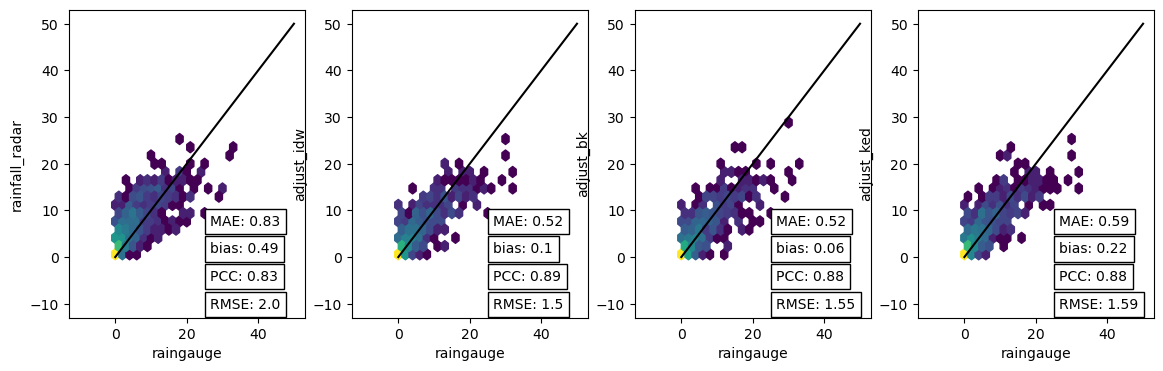

In [32]:
max_ = 50
min_ = -10
extent = [min_, max_, min_, max_]
gridsize = 30

pred_models = [
    ds_gauges_h.rainfall_radar, 
    ds_gauges_h.adjust_idw, 
    ds_gauges_h.adjust_bk, 
    ds_gauges_h.adjust_ked,
    # ds_gauges_h.cml_closest
]

fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4), sharex = True)
ground = ds_gauges_h.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()

    keep = ~np.isnan(ground) & ~np.isnan(tar)
    
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")
    ax[i].set_ylabel(pred_models[i].name)
    ax[i].set_xlabel('raingauge')

plt.show()